In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr, spearmanr, kendalltau


In [19]:
fig_width = 6.3  
fig_height = 3.54  
#plt.rcParams['figure.figsize'] = (fig_width, fig_height) # установка размеров для всех графиков
warnings.simplefilter(action='ignore', category=FutureWarning) #отключение предупреждений так как требуется легенда

Фильтрация данных для таблицы

In [44]:
file_path = "D:/AI/Computerized-campimetry-test-analysis/summary_per_color_group.xlsx"
data_t = pd.read_excel(file_path)
test_data = data_t.rename(columns=lambda x: x.replace('T258', 'CM')) #замена названий столбцов

Фильтрация данных для графиков

In [20]:
file_path = "D:/AI/Computerized-campimetry-test-analysis/data_for_analysis.csv"  
data = pd.read_csv(file_path, sep=',')
#data = data[data["id_test_attempt"]>0]
data


,CM_dH+_yellow_green_50%,CM_dH+_blue_50%,CM_dH+_purple_50%,CM_dH+_red_50%,id_test_attempt
0,4.0,1.0,2.0,3.0,0
1,4.0,1.0,2.0,2.5,0
2,2.0,1.0,1.0,1.5,0
3,4.0,1.0,3.0,2.0,0
4,3.0,2.0,2.0,2.0,1
...,...,...,...,...,...
2998,4.0,3.0,6.0,7.5,0
2999,9.0,4.0,6.0,7.5,0
3000,5.0,3.0,9.0,10.0,0
3001,28.0,8.0,9.0,13.0,0


## Построение графиков boxplot

Boxplot это графический способ представления распределения данных, который позволяет визуально оценить ключевые статистические характеристики набора данных. Он особенно полезен для выявления выбросов, асимметрии и сравнения распределений между различными группами данных. Коробка охватывает центральные 50% наблюдений, показывая разброс между первым и третьим квартилями (Q1 и Q3). Внутри коробки расположена медиана, которая делит данные на две равные части. Усы, идущие от коробки, показывают нормальный диапазон данных, а точки за пределами усов считаются выбросами

In [29]:
def build_boxplots(data):
    test_data = data.drop("id_test_attempt", axis=1)
    fig, axes = plt.subplots(nrows=1, ncols=len(test_data.columns), figsize=(5 * len(test_data.columns), 6))
    
    for i, col in enumerate(test_data.columns):
        
        sns.boxplot(x="id_test_attempt", y=col, ax=axes[i], data=data, palette="Set1", width=0.65)
        axes[i].set_xlabel('Номер попытки', fontsize=14, fontweight='light')
        col = col.replace('_', ' ') #изменение названий параметра для графика
        if (col == "CM dH+ yellow green 50%"):
                col = "CM dH+ yellow-green 50%"
        axes[i].set_ylabel(col, fontsize=14, fontweight='light')


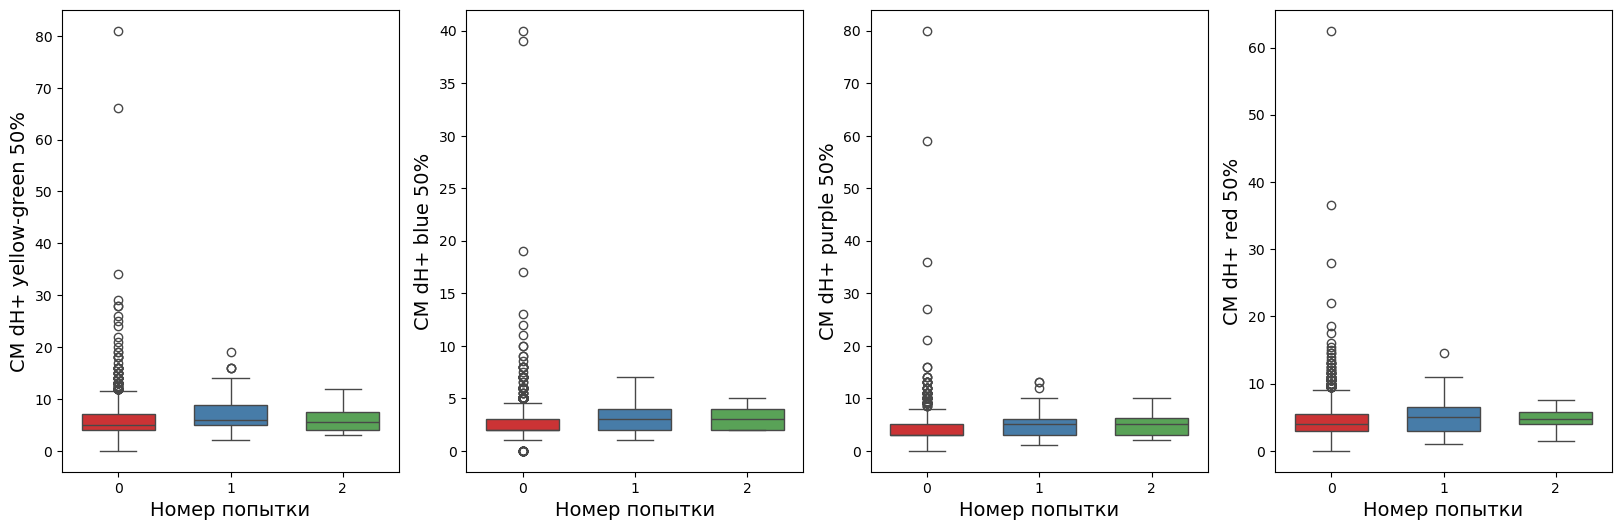

In [30]:
build_boxplots(data)

# Таблица с корреляциями


In [47]:
def calculate_correlations (data, particular_column, name_of_result_table, save_tab=True):
    
    # Задаем столбцы для итоговой таблицы
    columns = ['Показатель', 'Корреляция Пирсона', 'Pearson p-value','Статичтическая значимость', 
               'Корреляция Спирмана', 'Spearman p-value', 
               'Корреляция Кендалла', 'Kendall p-value']

    # Преобразование столбца particular_column в числовой формат
    data[particular_column] = pd.to_numeric(data[particular_column])
    
    # Создание пустой таблицы
    result_table = pd.DataFrame(columns=columns)
    
    # Перебор всех столбцов, начиная с 9-го и до предпоследнего
    for i in range(1, len(data.columns)-4):
       
        # Вычисление корреляций и ошибки
        Pearson, Pear_p = pearsonr(data[particular_column], data[data.columns[i]])
        Spearman, Spear_p = spearmanr(data[particular_column], data[data.columns[i]])
        Kendall, Ken_p = kendalltau(data[particular_column], data[data.columns[i]])
        
        if Pear_p<0.05:
            importance = "Присутствует"
        else:
            importance = "Отсутствует"

        # Добавление строки с результатами в таблицу
        result_table.loc[i-1] = [data.columns[i], Pearson, Pear_p, importance, Spearman, Spear_p, 
                                 Kendall, Ken_p]
    
    # Сортировка таблицы по корреляции Пирсона
    result_table_sorted = result_table.sort_values(by='Корреляция Пирсона', ascending=False) #ascending false это сортировка 
                                                                                             #по убыванию
    result_table_sorted = result_table_sorted.reset_index(drop=True) #создание новых индекс по порядку, если drop=false
                                                                     # то 2 столбца с новыми и старыми индексами
    
    # Разделение на таблицы с положительной и отрицательной корреляцией
    positive_corr_table = result_table_sorted[result_table_sorted['Корреляция Пирсона'] >= 0]
    negative_corr_table = result_table_sorted[result_table_sorted['Корреляция Пирсона'] < 0]
    
    #сортировка negative cor в порядке от большего к меньшему
    negative_corr_table = negative_corr_table.sort_values(by='Корреляция Пирсона', ascending=True)
    negative_corr_table = negative_corr_table.reset_index(drop=True) #сброс индексов
    
    if save_tab:
        # Сохранение результатов в Excel pandas
        with pd.ExcelWriter(name_of_result_table) as writer:  #вместо name можно путь вставить
            positive_corr_table.to_excel(writer, sheet_name='Positive Correlation', index=False)
            negative_corr_table.to_excel(writer, sheet_name='Negative Correlation', index=False)
            result_table_sorted.to_excel(writer, sheet_name='General', index=False)

    # Настройка ширины таблицы и вывод на экран
    pd.set_option('display.width', 130)
    #print(result_table_sorted)
    return result_table

Нулевая гипотеза это отсутствие корреляции, поэтому если p-value(уровень значимости) меньше чем 0.05, то нулевая гипотеза отклоняется и корреляция статистически значима

In [48]:
calculate_correlations(test_data, "age", "correlation table.xlsx")

,Показатель,Корреляция Пирсона,Pearson p-value,Статичтическая значимость,Корреляция Спирмана,Spearman p-value,Корреляция Кендалла,Kendall p-value
0,CM_dH+_red_mean,0.141060,8.121923e-15,Присутствует,0.271577,6.315562e-52,0.187944,8.173881e-52
1,CM_dH+_red_std,0.072301,7.320026e-05,Присутствует,0.193824,8.304176e-27,0.131460,1.784089e-26
2,CM_dH+_red_min,0.182674,6.034579e-24,Присутствует,0.201430,7.312485e-29,0.152792,5.296024e-29
3,CM_dH+_red_25%,0.274340,5.420621e-53,Присутствует,0.282209,4.248107e-56,0.199517,2.345492e-56
4,CM_dH+_red_50%,0.268131,1.296972e-50,Присутствует,0.271508,6.710917e-52,0.191309,8.454264e-52
...,...,...,...,...,...,...,...,...
352,T278_SMR_diff_50%,0.018135,3.204980e-01,Отсутствует,0.025668,1.596458e-01,0.017199,1.580320e-01
353,T278_SMR_diff_75%,-0.038087,3.688371e-02,Присутствует,-0.034097,6.172799e-02,-0.022678,6.249123e-02
354,T278_SMR_diff_max,-0.063475,5.005296e-04,Присутствует,-0.063457,5.023819e-04,-0.042134,5.380108e-04
355,T278_SMR_corr,-0.020561,2.600118e-01,Отсутствует,-0.027136,1.371008e-01,-0.018080,1.374963e-01
